# SVD implementation

In [1]:
!pip3 install surprise
!pip install --upgrade numpy
!pip install recommenders[examples]

In [2]:
import surprise
from surprise import SVD
from surprise import Dataset, accuracy, Reader

from surprise.model_selection import cross_validate, KFold, GridSearchCV
from collections import defaultdict
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from recommenders.datasets.python_splitters import python_random_split
from recommenders.utils.timer import Timer

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
"""my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)"""

'my_seed = 0\nrandom.seed(my_seed)\nnp.random.seed(my_seed)'

In [3]:
def _print(message, verbose):
    if verbose:
        print(message)
        
def load_dataset(data_f):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating"]] = pd.read_json(data_f)[["userID", "itemID", "rating"]]
    except:
        df = pd.read_json(data_f)
    return df

def filter_on_minimal_ratings(df):
    # Divide into preferred and non-preferred/not-seen
    df_preferred = df[df['rating'] > 3.5]
    df_low_rating = df[df['rating'] <= 3.5]

    # Keep users who clicked on at least 3 products
    df = min_rating_filter_pandas(df_preferred, min_rating=3, filter_by="user")

    # Keep products that were clicked on by at least on 1 user
    df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")
    df.reset_index(drop=True, inplace=True)
    return df, df_low_rating

def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    drop_indices = np.random.choice(df.index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True)

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    return df

def split_dataframe(df, val_percentage=0.1, test_percentage=0.2):
    unique_users = sorted(df.userID.unique())
    np.random.seed(SEED)
    unique_users = np.random.permutation(unique_users)
    
    # Create train/validation/test users 
    # The order of splitting is val, test and then training to solve the rounding error for int() on line 5, 6
    n_users = len(unique_users)
    _print(f"Number of unique users: {n_users}")
    HELDOUT_USERS_VAL = int(val_percentage * n_users)
    HELDOUT_USERS_TEST = int(test_percentage * n_users)

    val_users = unique_users[:HELDOUT_USERS_VAL]
    _print(f"\nNumber of validation users: {len(val_users)}")

    test_users = unique_users[HELDOUT_USERS_VAL:(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST)]
    _print(f"\nNumber of test users: {len(test_users)}")

    train_users = unique_users[(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST):]
    _print(f"\nNumber of training users: {len(train_users)}")
    
    # For training set keep only users that are in train_users list
    train_set = df.loc[df['userID'].isin(train_users)]
    _print(f"Number of training observations: {train_set.shape[0]}")

    # For validation set keep only users that are in val_users list
    val_set = df.loc[df['userID'].isin(val_users)]
    _print(f"\nNumber of validation observations: {val_set.shape[0]}")

    # For test set keep only users that are in test_users list
    test_set = df.loc[df['userID'].isin(test_users)]
    _print(f"\nNumber of test observations: {test_set.shape[0]}")

    # Obtain list of unique movies used in training set
    unique_train_items = pd.unique(train_set['itemID'])
    _print(f"Number of unique items that rated in training set {unique_train_items.size}")
    
    # For validation set keep only movies that used in training set
    val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
    _print(f"Number of validation observations after filtering: {val_set.shape[0]}")

    # For test set keep only movies that used in training set
    test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
    _print(f"\nNumber of test observations after filtering: {test_set.shape[0]}")
    return train_set, val_set, test_set
    

def build_data(df):
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df, reader)
    return data

In [4]:
def data_loading_pipeline(fp, sparsity_percentage=None):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.

    output: trainset and testset 
    """
    df = load_dataset(fp)
    df = filter_to_sparsity(df, sparsity_percentage)
    train, test = python_random_split(df, 0.8)

    return train, test

### Simulation

In [5]:
"""Results dic will contain the values of the metric at different sparcities, the arrays
correspond to precision, recall and ndcg, respectively"""
results = {0.75: [[], [], [], [], [], [], [], []],
           0.80: [[], [], [], [], [], [], [], []],
           0.85: [[], [], [], [], [], [], [], []],
           0.90: [[], [], [], [], [], [], [], []], 
           0.95: [[], [], [], [], [], [], [], []]}
spt = [0.75, 0.8 , 0.85, 0.9 , 0.95]

In [6]:
for spar in spt:     
    train, test = data_loading_pipeline("../data/AMAZON_FASHION_5.71.268.json", spar)
    
    reader = Reader(rating_scale=(1,5))
    train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

    param_grid = {'n_factors':[100,150,200],'n_epochs': [20,30,40,50,60,70,80]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
    gs.fit(train_set)
    
    for inter in range(20):
        np.random.seed(inter)

        sim_options = {'name': 'pearson_baseline', 'user_based': False }

        #svd = gs.best_estimator['rmse']
        svd = SVD(n_factors =gs.best_params['rmse']['n_factors'],n_epochs=gs.best_params['rmse']['n_epochs'])
        trainset = train_set.build_full_trainset()
        svd.fit(trainset)

        predictions = predict(svd, test, usercol='userID', itemcol='itemID')

        with Timer() as test_time:
            all_predictions = compute_ranking_predictions(svd, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
        print("Took {} seconds for prediction.".format(test_time.interval))

        k=10

        
        precisions = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
        recalls = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)
        ndcg_val = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
        map_val = map_at_k(test, all_predictions, col_prediction='prediction', k=k)

        results[round(spar,2)][0].append(precisions)
        results[round(spar,2)][1].append(recalls)
        results[round(spar,2)][2].append(ndcg_val)
        results[round(spar,2)][3].append(map_val)
        
        eval_rmse = rmse(test, predictions)
        eval_mae = mae(test, predictions)
        eval_rsquared = rsquared(test, predictions)
        eval_exp_var = exp_var(test, predictions)

        results[round(spar,2)][4].append(eval_rmse)
        results[round(spar,2)][5].append(eval_mae)
        results[round(spar,2)][6].append(eval_rsquared)
        results[round(spar,2)][7].append(eval_exp_var)

    print(results)

To obtain a sparsity of 75.0% we need to drop 391 ratings
Took 0.0871385790005661 seconds for prediction.
Took 0.09129716400002508 seconds for prediction.
Took 0.07966611099982401 seconds for prediction.
Took 0.09758747600062634 seconds for prediction.
Took 0.1187791920001473 seconds for prediction.
Took 0.08727068999996845 seconds for prediction.
Took 0.07747423599994363 seconds for prediction.
Took 0.08506371099974785 seconds for prediction.
Took 0.18230299199967703 seconds for prediction.
Took 0.09847872299997107 seconds for prediction.
Took 0.07866759699936665 seconds for prediction.
Took 0.1285982180006613 seconds for prediction.
Took 0.07740665399978752 seconds for prediction.
Took 0.09072172100059106 seconds for prediction.
Took 0.07829777499955526 seconds for prediction.
Took 0.07881110899961641 seconds for prediction.
Took 0.0787580579999485 seconds for prediction.
Took 0.08302098400054092 seconds for prediction.
Took 0.09902737799984607 seconds for prediction.
Took 0.08859541

In [7]:
r_pres = []
r_recl = []
r_ndcg = []
r_maps = []
r_rmse = []
r_mae = []
r_rsquared = []
r_expvar = []
for i in results:
    r_pres.append(np.mean(results[i][0]))
    r_recl.append(np.mean(results[i][1]))
    r_ndcg.append(np.mean(results[i][2]))
    r_maps.append(np.mean(results[i][3]))
    
    r_rmse.append(np.mean(results[i][4]))
    r_mae.append(np.mean(results[i][5]))
    r_rsquared.append(np.mean(results[i][6]))
    r_expvar.append(np.mean(results[i][7]))
print(r_pres,'\n', r_recl,'\n', r_ndcg, '\n', r_maps)

[0.13181355932203392, 0.11543071161048694, 0.11216599190283402, 0.10164383561643835, 0.09180628272251308] 
 [0.7397598870056498, 0.7132022471910113, 0.7543522267206477, 0.7270357686453577, 0.6804101221640488] 
 [0.5989918341045277, 0.515987275062673, 0.48844068663683854, 0.4214291056784377, 0.34203403288636147] 
 [0.5439267206976953, 0.43855351074054266, 0.38982241929610356, 0.31303820576937014, 0.22823275921770683]


In [8]:
r_rsquared

[0.9905571052069655,
 0.9621301600463529,
 0.9498923839251013,
 0.8052962851122645,
 0.8146458051719009]

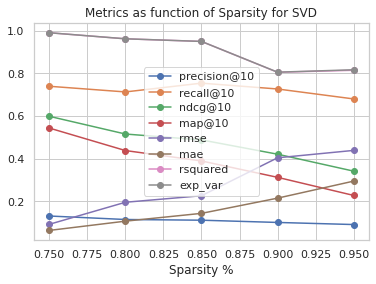

In [10]:
sns.set(style='whitegrid')
plt.plot(spt,r_pres,label="precision@10", marker = "o")
plt.plot(spt,r_recl,label="recall@10", marker = "o")
plt.plot(spt,r_ndcg,label="ndcg@10", marker = "o")
plt.plot(spt,r_maps,label="map@10", marker = "o")
plt.plot(spt,r_rmse,label="rmse", marker = "o")
plt.plot(spt,r_mae,label="mae", marker = "o")
plt.plot(spt,r_rsquared,label="rsquared", marker = "o")
plt.plot(spt,r_expvar,label="exp_var", marker = "o")


plt.title("Metrics as function of Sparsity for SVD")
plt.xlabel("Sparsity %")
plt.legend()
plt.savefig("../results/metrics_over_sparsity_svd.png")

plt.show()

In [11]:
import json

with open("../results/results_svd.json", "w") as op:
    json.dump(results, op)